In [157]:
import plotly as py
# ^^^ pyforest auto-imports - don't write above this line
from __future__ import absolute_import,division,print_function,unicode_literals

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import os
from datetime import datetime

import pandas as pd

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from download import download

from sklearn.metrics import mean_squared_error as mse

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

print("Import Succesfull")

Import Succesfull


In [158]:
import os
os.chdir(r"C:\Users\eanusau\Documents\AI\Stat\Projects\TimeSeries")

    Industrial Production: Electric and gas utilities (IPG2211A2N)
    Not Seasonally Adjusted
    Frequency:Monthly
    https://fred.stlouisfed.org/series/IPG2211A2N
    The industrial production (IP) index measures the real output of all relevant establishments located in the United  
    States

In [159]:
data = pd.read_csv('Electric_Production.csv')
df = data.copy()
df.head()

,DATE,IPG2211A2N
0,1939-01-01,3.3842
1,1939-02-01,3.4100
2,1939-03-01,3.4875
3,1939-04-01,3.5133
4,1939-05-01,3.5133


In [160]:
df.columns = ['Date', 'Energy Production']

In [161]:
df

,Date,Energy Production
0,1939-01-01,3.3842
1,1939-02-01,3.4100
2,1939-03-01,3.4875
3,1939-04-01,3.5133
4,1939-05-01,3.5133
...,...,...
974,2020-03-01,97.8951
975,2020-04-01,86.3541
976,2020-05-01,86.9068
977,2020-06-01,99.5332


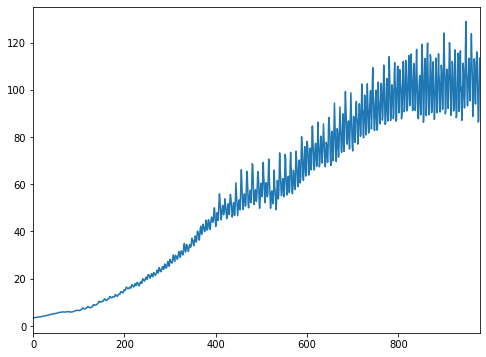

In [162]:
df['Energy Production'].plot()

In [163]:
df['Date']  = df['Date'].astype('datetime64[ns]')

In [164]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 979 entries, 0 to 978
Data columns (total 2 columns):
Date                 979 non-null datetime64[ns]
Energy Production    979 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 15.4 KB


In [165]:
import plotly.express as px
fig = px.line(df, x = 'Date',y = 'Energy Production',title = 'Energy_Production')

fig.update_xaxes(
    rangeslider_visible= True,
    rangeselector=dict(
                        buttons = list([
                        dict(count = 1,label = '1m',step='month',stepmode = "backward"),
                        dict(count = 2,label = '6m',step='month',stepmode = "backward"),
                        dict(count = 3,label = '6mYTD',step='month',stepmode = "todate"),
                        dict(count = 4,label = '2y',step='year',stepmode = "backward"),
                        dict(count = 5,label = '3y',step='year',stepmode = "backward"),
                        dict(step= 'all')
                            ])        
                        )
                   )
fig.show()

In [166]:
df.set_index('Date', inplace=True)

In [167]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 979 entries, 1939-01-01 to 2020-07-01
Data columns (total 1 columns):
Energy Production    979 non-null float64
dtypes: float64(1)
memory usage: 15.3 KB


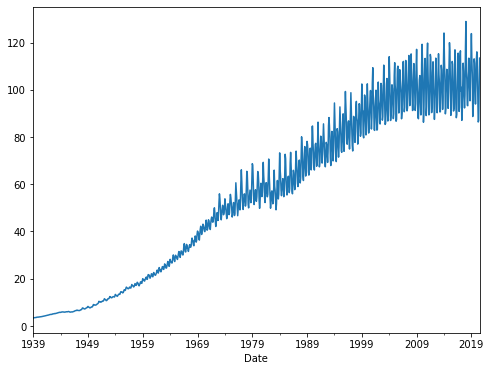

In [168]:
df['Energy Production'].plot()

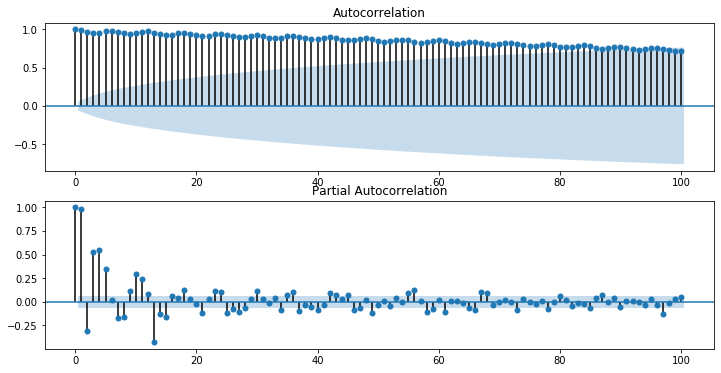

In [169]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(df['Energy Production'].dropna(), ax=ax[0], lags=100)
ax[1] = plot_pacf(df['Energy Production'].dropna(), ax=ax[1], lags=100)

In [170]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        test_statistic = sm.tsa.stattools.adfuller(y,regresults=True)[0]
        p_value = sm.tsa.stattools.adfuller(y)[1]
        print("Test statistic = {:.3f}".format(test_statistic))
        print("P-value = {:.3f}".format(p_value))
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

Test statistic = -0.721
P-value = 0.841


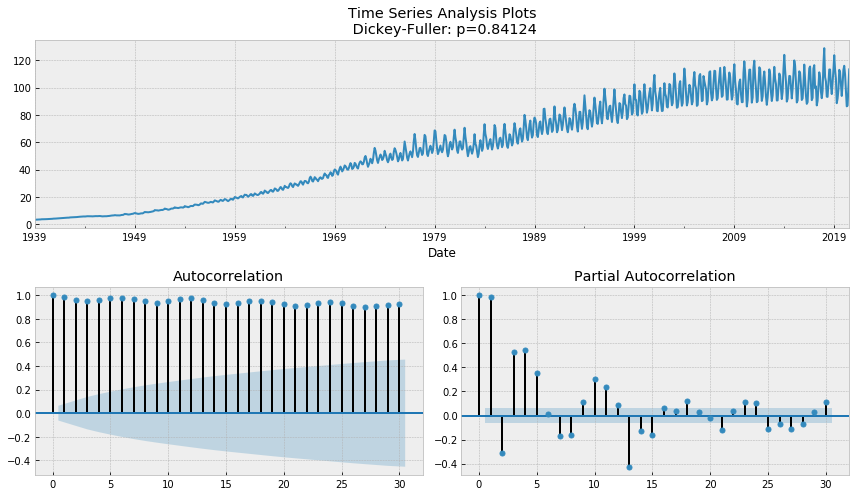

In [171]:
tsplot(df['Energy Production'])

In [172]:
## MAPE

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true-y_pred)/ y_true)) * 100

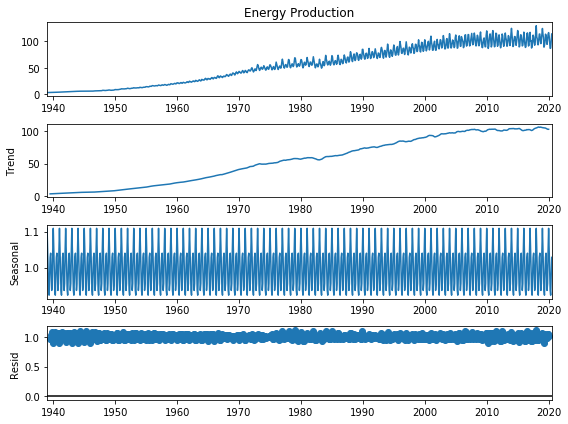

In [173]:
## Decomposition of time series

import statsmodels.api as sm
# deal with missing values.
df['Energy Production'].interpolate(inplace=True)
res = sm.tsa.seasonal_decompose(df['Energy Production'],model='multiplicative')
resplot = res.plot()

In [174]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 979 entries, 1939-01-01 to 2020-07-01
Data columns (total 1 columns):
Energy Production    979 non-null float64
dtypes: float64(1)
memory usage: 15.3 KB


In [175]:
#H0: Series is stationary
#H1: Series is not stationary

from statsmodels.tsa.stattools import kpss
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')


stats, p, lags, critical_values = kpss(df['Energy Production'], 'c')
print(f'Test Statistics: {stats}')
print(f'p-value: {p}')
print(f'Critical values: {critical_values}')

if p < 0.05:
    print('\nWe reject the null hypothesis i.e. Series is not stationary')
else:
    print('\nWe fail to reject the null hypothesis i.e. Series is stationary')


Test Statistics: 4.364620318120944
p-value: 0.01
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

We reject the null hypothesis i.e. Series is not stationary


In [176]:
# Adfuller test

   # Ho: Series possess a unit root and hence is not stationary
   # H1: Series is stationary

from statsmodels.tsa.stattools import adfuller
result = adfuller(df['Energy Production'])
print(f'Test Statistics: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critical values: {result[4]}')

if result[1] < 0.05:
    print('\nWe reject the null hypothesis i.e. Series is stationary')
else:
    print('\nWe fail to reject the null hypothesis i.e. Series is NOT stationary')

Test Statistics: -0.7209808933942852
p-value: 0.8412399105457927
Critical values: {'1%': -3.4372087295925664, '5%': -2.8645680048962348, '10%': -2.5683822785402914}

We fail to reject the null hypothesis i.e. Series is NOT stationary


# Using SARIMA

Test statistic = -0.721
P-value = 0.841


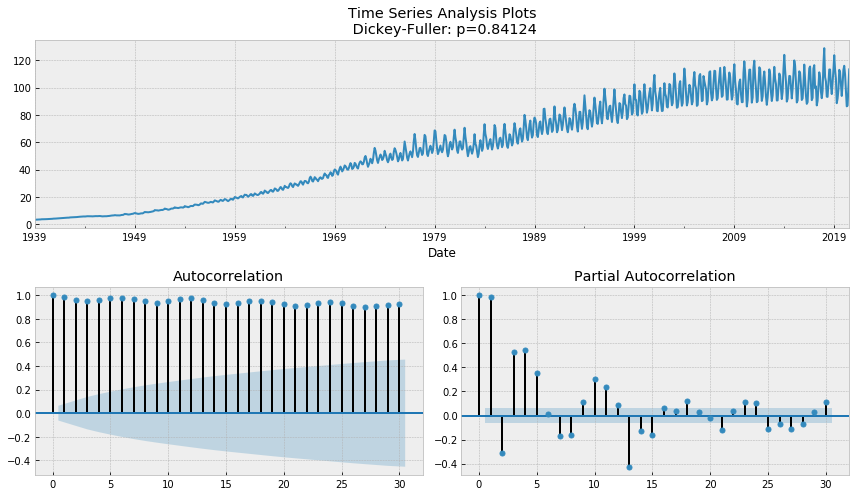

In [177]:
tsplot(df['Energy Production'])

In [178]:
import pmdarima as pm
import time
#by default auto arima uses AIC,the lower aic the model is good
%time
model = pm.auto_arima(df['Energy Production'],
                      m = 12, seasonal = True,
                      start_p = 0,start_q=0,max_p=3, max_q=3,max_order=4,test='adf',error_action = 'ignore',
                      suppress_warnings =True,
                      stepwise =True,trace = True)

Wall time: 0 ns
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=4168.501, Time=1.08 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6129.227, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5283.133, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6127.630, Time=0.02 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=5387.444, Time=0.27 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=4165.433, Time=3.09 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=1.60 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=4157.723, Time=6.83 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=4208.789, Time=6.72 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=4126.450, Time=7.86 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=4134.321, Time=3.99 sec
 ARIMA(1,1,0)(1,0,1)[12]

 ARIMA(3,1,1)(2,0,2)[12]             : AIC=3957.019, Time=6.83 sec

In [179]:
model.aic()

3957.019210187945

In [180]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  979
Model:             SARIMAX(3, 1, 1)x(2, 0, [1, 2], 12)   Log Likelihood               -1969.510
Date:                                 Thu, 27 Aug 2020   AIC                           3957.019
Time:                                         18:46:51   BIC                           4000.989
Sample:                                              0   HQIC                          3973.749
                                                 - 979                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5770      0.023     25.168      0.000       0.532       0.622
ar.L2         -0.0874      0.023     -3.823      0.000      -0.132      -0.043
ar.L3          0.0564      0.026      2.154      0.031       0.005       0.108
ma.L1         -0.9450      0.012    -75.955      0.000      -0.969      -0.921
ar.S.L12       0.6141      0.148      4.158      0.000       0.325       0.904
ar.S.L24       0.3795      0.146      2.596      0.009       0.093       0.666
ma.S.L12      -0.2152      0.148     -1.454      0.146      -0.505       0.075
ma.S.L24      -0.3737      0.091     -4.127      0.000      -0.551      -0.196
sigma2         3.1687      0.091     34.772      0.000       2.990       3.347
===================================================================================
Ljung-Box (Q):                      110.12   Jarque-Bera (JB):               626.12
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):             123.01   Skew:                            -0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [181]:
model.arparams()

array([ 0.57701871, -0.08744504,  0.05641798])

In [182]:
print ("Sum of AR coefficients:", (0.57701871 -0.08744504 +  0.05641798))

Sum of AR coefficients: 0.54599165


## Train Test Split

In [183]:
train = df.loc['2000':'2018']
test  = df.loc['2019':]
print(train.shape)
print(test.shape)

(228, 1)
(19, 1)


## Train the model

In [184]:
model.fit(train)

ARIMA(maxiter=50, method='lbfgs', order=(3, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(2, 0, 2, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

## Evaluate the model

In [185]:
forecast = model.predict(n_periods=19,return_conf_int=True)

In [186]:
type(forecast)

tuple

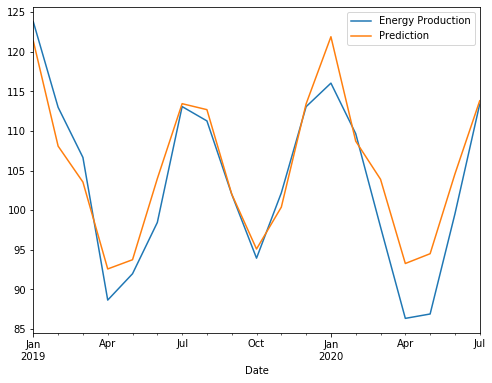

In [187]:
df_forecast = pd.DataFrame(forecast[0],index = test.index,columns=['Prediction'])
pd.concat([test,df_forecast],axis=1).plot()

In [188]:
df_final =  pd.merge(test, df_forecast, on='Date')

In [189]:
df_final

,Energy Production,Prediction
Date,,
2019-01-01,123.7687,121.345284
2019-02-01,112.9837,108.087179
2019-03-01,106.6593,103.553683
2019-04-01,88.6631,92.590902
2019-05-01,91.9852,93.753859
2019-06-01,98.4548,103.985474
2019-07-01,113.0791,113.445775
2019-08-01,111.2697,112.690594
2019-09-01,102.0185,102.031142


In [190]:
pd.concat([test,df_forecast],axis=1)

,Energy Production,Prediction
Date,,
2019-01-01,123.7687,121.345284
2019-02-01,112.9837,108.087179
2019-03-01,106.6593,103.553683
2019-04-01,88.6631,92.590902
2019-05-01,91.9852,93.753859
2019-06-01,98.4548,103.985474
2019-07-01,113.0791,113.445775
2019-08-01,111.2697,112.690594
2019-09-01,102.0185,102.031142


In [191]:
print("RMSE :%.3f" % np.sqrt(mse(df_final['Energy Production'], df_final['Prediction'])))
print("MAPE  :%.3f" % mean_absolute_percentage_error(df_final['Energy Production'], df_final['Prediction']))

RMSE :3.962
MAPE  :3.176


## Lets predict in future from 2020-08-01 to 2020-12-01.

In [211]:
forecast_range = pd.date_range(start='2019-01-01',periods=24,freq='MS')
forecast_range

DatetimeIndex(['2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
               '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
               '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [202]:
new_forecast = model.predict(n_periods=24,return_conf_int=True)

In [203]:
#Confidene interval
lower = pd.Series(new_forecast[1][:,0],index=forecast_range)
upper = pd.Series(new_forecast[1][:,1],index=forecast_range)

In [204]:
forcast_df = pd.DataFrame(new_forecast[0], index=forecast_range, columns=['Prediction'])

In [207]:
forcast_df = pd.concat([forcast_df, lower, upper], axis=1)
forcast_df.columns = ['Prediction','lower','upper']
forcast_df

,Prediction,lower,upper
2019-01-01,121.345284,115.699727,126.990840
2019-02-01,108.087179,101.457335,114.717024
2019-03-01,103.553683,96.801042,110.306324
2019-04-01,92.590902,85.775839,99.405965
2019-05-01,93.753859,86.882965,100.624753
2019-06-01,103.985474,97.079031,110.891916
2019-07-01,113.445775,106.515604,120.375945
2019-08-01,112.690594,105.740574,119.640615
2019-09-01,102.031142,95.063018,108.999265
2019-10-01,95.107493,88.122527,102.092460


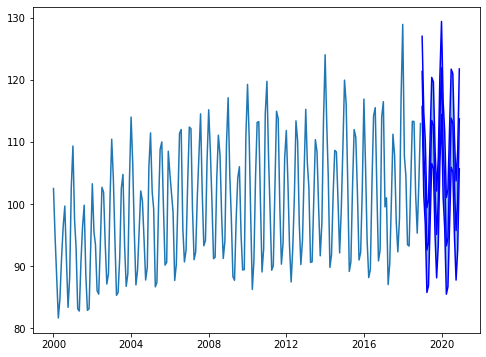

In [209]:
plt.plot(df.loc['2000':'2018'])
plt.plot(forcast_df,color='blue')
plt.fill_between(forecast_range,lower,upper,alpha = 0.5)
plt.show()

## Now that we’ve evaluated our data on the test set and our satisfied with the performance, the next step would be to refit our model to our entire data set and then forecast into the real future.

In [212]:
model.fit(df)

ARIMA(maxiter=50, method='lbfgs', order=(3, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(2, 0, 2, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [213]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 979 entries, 1939-01-01 to 2020-07-01
Data columns (total 1 columns):
Energy Production    979 non-null float64
dtypes: float64(1)
memory usage: 55.3 KB


In [215]:
forecast_range = pd.date_range(start='2020-08-01',periods=24,freq='MS' )
forecast_range

DatetimeIndex(['2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01',
               '2020-12-01', '2021-01-01', '2021-02-01', '2021-03-01',
               '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01',
               '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01',
               '2021-12-01', '2022-01-01', '2022-02-01', '2022-03-01',
               '2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01'],
              dtype='datetime64[ns]', freq='MS')

In [216]:
forecast_ahead = model.predict(n_periods=24,return_conf_int=True)

In [217]:
#Confidene interval
lower = pd.Series(forecast_ahead[1][:,0],index=forecast_range)
upper = pd.Series(forecast_ahead[1][:,1],index=forecast_range)

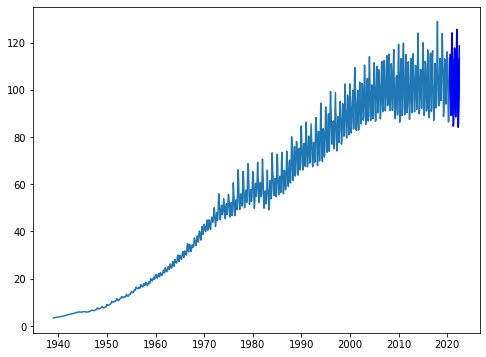

In [218]:
forcast_df = pd.DataFrame(forecast_ahead[0], index=forecast_range, columns=['Prediction'])
forcast_df = pd.concat([forcast_df, lower, upper], axis=1)
forcast_df.columns = ['Prediction','lower','upper']
plt.plot(df['Energy Production'])
plt.plot(forcast_df,color='blue')
plt.fill_between(forecast_range,lower,upper,alpha = 0.5)
plt.show()